## Imports

In [151]:
%load_ext autoreload
%autoreload 2
import torch
from torch import Tensor

from Datasets.Dataset_Loaders.breast_cancer_dataset_loader import prepare_wisc_breast_cancer_dataset
from Datasets.Dataset_Loaders.kbit_parity_datset_loader import generate_k_bit_parity_dataset
from Utils.neural_network import initialize_FC_neural_net, add_neuron_to_network, compute_accuracy, forward_pass
from Utils.newton_update import compute_minimizer
from Utils.plotting import plot_loss_profile

# Globals
USE_KBIT_DATASET = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Loading Examples

In [3]:
# k-bit parity dataset generation
if USE_KBIT_DATASET:
    X, y = generate_k_bit_parity_dataset(k=4)
    print(f"X shape: {X.shape}")
    print(f"Y shape: {y.shape}")

X shape: torch.Size([16, 4])
Y shape: torch.Size([16, 1])


In [4]:
# Breast cancer dataset loading
if not USE_KBIT_DATASET:
    X, y = prepare_wisc_breast_cancer_dataset(convert_to_tensor=True)
    print(f"X shape: {X.shape}")
    print(f"Y shape: {y.shape}")

## Feedforward Neural Network Construction Algorithm

In [133]:
def run_FNNCA(X: Tensor, y_true: Tensor, 
              acc_threshold: float, max_hidden_units: int, device):
    """ Description: Performs Feedforward Neural Network Construction 
                    Algorithm with BFGS/SR1 update method.
        Args:
            X (Tensor): Input tensor of feature vectors
            y_true (Tensor): Input tensor of true labels
            acc_threshold (float): Accuray threshold for the given
                                classification problem
            max_hidden_units (int): Max number of hidden units that can be added
                                    before termination if acc_threshold not reached
        Returns:
            W (Tensor): Weight of optimized neural network for given problem
            training_results (dict): Dictionary storing the sequence of training losses for each
                                     number of hidden units tested
    """
    # Create dict to store losses for each number of hidden units tested
    training_results = {}
    n_iterations = 0 
    # Initialize neural network with 2 initial hidden units
    n_hidden = 2
    n_feats = X.shape[1]
    W_init = initialize_FC_neural_net(n_feats, n_hidden, device)
    W = W_init
    accuracy = 0

    while True:
        # Compute minimizer for current number of hidden units and track results
        W, training_losses = compute_minimizer(W, X, y_true, n_hidden, device)

        training_results[n_hidden] = {
            "training_loss": training_losses,
            "iterations": list(range(n_iterations, n_iterations+ len(training_losses)))
        }
        n_iterations += len(training_losses)
        _, _, _, y_hat = forward_pass(X, W, n_feats, n_hidden)
        accuracy = compute_accuracy(y_hat, y_true)
        print(f"Number of hidden units: {n_hidden} | Accuracy after optimization: {accuracy}")
        # If accuracy is sufficient or max network size reached, terminate
        if (accuracy >= acc_threshold or n_hidden == max_hidden_units):
            break
        # Otherwise, add another neuron and reoptimize
        else: 
            W, n_hidden = add_neuron_to_network(W, n_feats, 
                                    n_output_neurons=1, n_hidden=n_hidden, device=device)
    return W, training_results

## Reproduce Study Results

In [ ]:
## kbit parity problem
X, y_true = generate_k_bit_parity_dataset(k=4)
X, y_true = X.to(DEVICE), y_true.to(DEVICE)
W_final, training_results = run_FNNCA(X, y_true, acc_threshold=100, max_hidden_units=10, device=DEVICE)
plot_loss_profile(training_results, plot_title=f"Error vs Iteration for 5-bit parity problem with increasing hidden units (h)",
                  output_plot_name="testing.png")


Iteration 313 | grad norm: 1.08e-08:  31%|███▏      | 313/1000 [00:01<00:03, 174.50it/s]


Number of hidden units: 2 | Accuracy after optimization: 75.0


Iteration 104 | grad norm: 0.00e+00:  10%|█         | 104/1000 [00:00<00:02, 343.23it/s]


Number of hidden units: 3 | Accuracy after optimization: 81.25


Iteration 64 | grad norm: 4.13e-05:   6%|▋         | 64/1000 [00:00<00:01, 628.55it/s]


Number of hidden units: 4 | Accuracy after optimization: 100.0


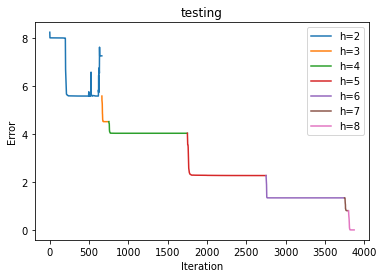

In [150]:
plot_loss_profile(training_results, "testing", "test.png")